# Multi Input Variables LSTM/RNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
import warnings
import urllib

warnings.filterwarnings("ignore")

# 데이터 다운로드
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed_table = confirmed_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Confirmed").fillna('').drop(['Lat', 'Long'], axis=1)
death_table = death_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Deaths").fillna('').drop(['Lat', 'Long'], axis=1)
recovered_table = recovered_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Recovered").fillna('').drop(['Lat', 'Long'], axis=1)

full_table = confirmed_table.merge(death_table).merge(recovered_table)

full_table['Date'] = pd.to_datetime(full_table['Date'])

Using TensorFlow backend.
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type

In [2]:
def get_time_series(country):
    # for some countries, data is spread over several Provinces
    if full_table[full_table['Country/Region'] == country]['Province/State'].nunique() > 1:
        country_table = full_table[full_table['Country/Region'] == country]
        country_df = pd.DataFrame(pd.pivot_table(country_table, values = ['Confirmed', 'Deaths', 'Recovered'],
                              index='Date', aggfunc=sum).to_records())
        return country_df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered']]
    df = full_table[(full_table['Country/Region'] == country) 
                & (full_table['Province/State'].isin(['', country]))]
    return df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered']]

Populating the interactive namespace from numpy and matplotlib


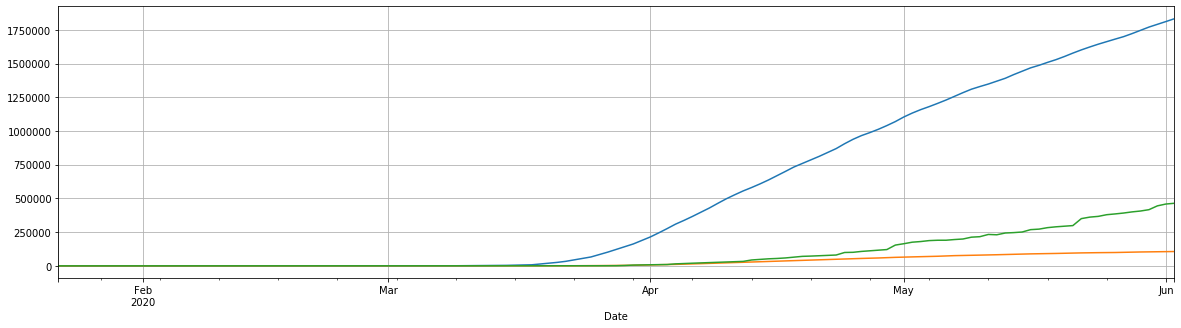

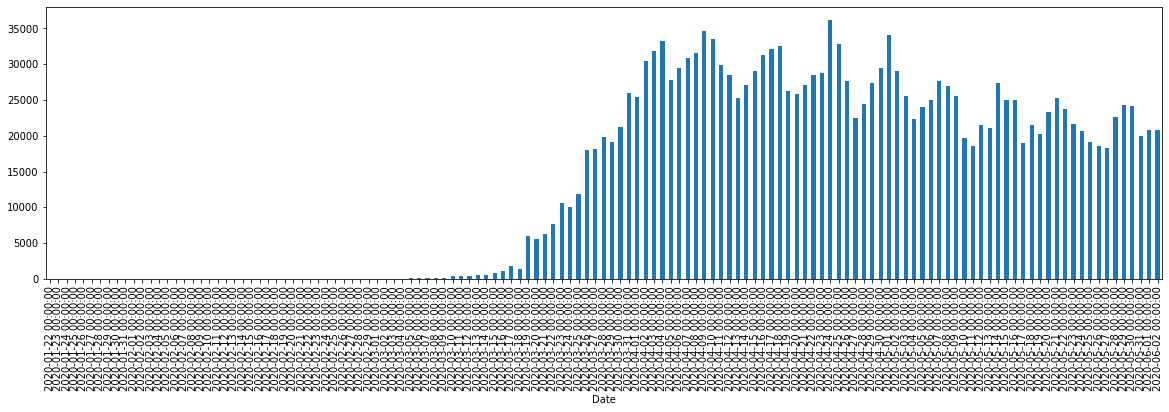

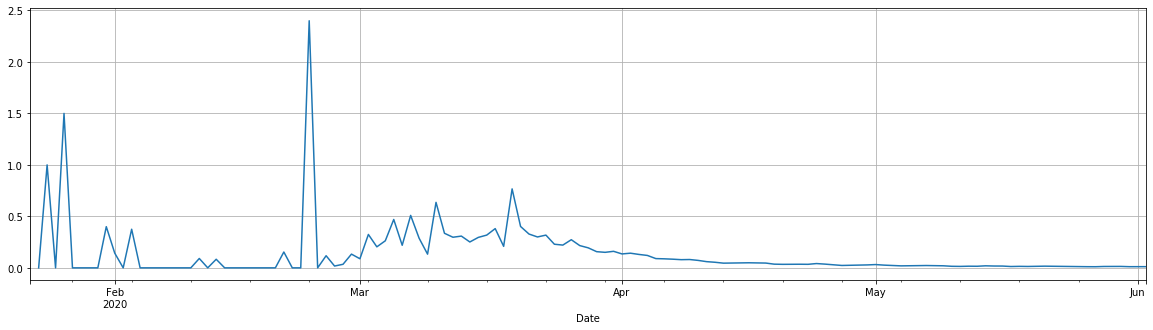

In [3]:
country = 'US'
df_country = get_time_series(country)
if len(df_country) > 1 and df_country.iloc[-2,0] >= df_country.iloc[-1,0]:
    df_country.drop(df_italy.tail(1).index,inplace=True)


%pylab inline
pylab.rcParams['figure.figsize'] = (20, 5)

# italy
df_country.Confirmed.plot(grid=True)
df_country.Deaths.plot(grid=True)
df_country.Recovered.plot(grid=True)
plt.show()

# Don't need apply() function since there are built-in functions, pct_change() and diff()
# http://www.leejungmin.org/post/2018/04/21/pandas_apply_and_map/
df_country['Pct_Change'] = df_country.Confirmed.pct_change()
df_country['Daily_Confirmed'] = df_country.Confirmed.diff()

df_country.Daily_Confirmed.plot(kind='bar')
plt.show()

df_country.Pct_Change.plot(grid=True)
plt.show()

In [4]:
np.set_printoptions(threshold=20)

# 하나의 나라만 가지고 학습을 할지
# 여러 나라 데이터를 모두 가지고 학습을 할지
# 여러 나라 데이터를 패턴 별로 분류해서 학습을 할지 결정 필요
# 위도/경도 정보를 통해 날씨/온도가 필요할 수도
df_train = df_country[:] #여기 조정하면 국가 변경 가능
df_train = df_train.dropna()
df_train = df_train[1:]

print(df_train.columns)

# df_train = df_train.drop(["SNo", "Province/State", "Country/Region", "Last Update"], 1)
# df_train = df_train.dropna()

df_train.tail(10)

# 7일치 데이터를 입력해서 다음 시간을 예측하는 모델
n_input = 7
# 입력 변수는 다섯 개 (Confirmed, Deaths, Recovered, Pct_Change, Daily_Confirmed)
# 입력 변수가 여러 개이면 Scaler도 각각에 맞게 골라야 함
n_features = 5

train, test = df_train[:-(n_input*2)], df_train[-(n_input*3):]
# print(test.shape)
print('len_train : ' + str(len(train)))
print('len_test : ' + str(len(test)))

# 정규화
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

# print(test.shape)
# print(train)
# print(test)

generator = TimeseriesGenerator(train, train[:, 0:1], length=n_input, batch_size=5)
print(len(generator))
x, y = generator[0]
# print("x: %s" % (x))
# print("y: %s" % (y))
print(x.shape)
print(y.shape)

# Keras의 NN 생성은 매우 쉬움 (Tensorflow에 비해 - 비교해 보기 바람)
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
model = Sequential()
# 출력이 200차원인 LSTM Network
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
# 과적합을 막기 위한 Dropout 비율 15%는 Network를 끊어버림
model.add(Dropout(0.15))
# 200차원의 LSTM NN 결과를 단일(1차원) 출력으로 줄임
model.add(Dense(1))
# Adam Optimzer(이런게 있다고 알아두면 됨)
# MSE(Mean Square Error) - 에러 함수를 평균 제곱의 합으로 설정 (RMSE 등이 있음)
model.compile(optimizer='adam', loss='mse')

# 100 차례 학습을 반복
model.fit_generator(generator, epochs=20)

Index(['Confirmed', 'Deaths', 'Recovered', 'Pct_Change', 'Daily_Confirmed'], dtype='object')
len_train : 117
len_test : 21
22
(5, 7, 5)
(5, 1)

Epoch 1/20
22/22 [==============================] - 1s 47ms/step - loss: 0.0787
Epoch 2/20
22/22 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 3/20
22/22 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 4/20
22/22 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 5/20
22/22 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 6/20
22/22 [==============================] - ETA: 0s - loss: 0.0021   - 0s 6ms/step - loss: 0.0019
Epoch 7/20
22/22 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 8/20
22/22 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 9/20
22/22 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 10/20
22/22 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 11/20
22/22 [==================

In [5]:
predicted_list = []

for i in range(len(train)-n_input):
    batch = train[i:i+n_input].reshape((1, n_input, n_features))
    
    predicted = np.array([model.predict(batch)[0][0], 0, 0, 0, 0])
    predicted = scaler.inverse_transform(predicted.reshape(1, -1))  # n_input==7
    # print(predicted)
    predicted_list.append(predicted[0][0])

print(predicted_list)
len(predicted_list)

[6461.317114297301, 4790.051823949441, 3371.7581252157693, 6525.980753047392, 5987.648095129058, 6656.321625219658, 6576.936662727967, 5861.301810948178, 6019.658895405009, 5990.748669842258, 5355.140818752348, 6219.169062418863, 5540.825098890811, 5915.055071093142, 5616.675292322412, 5939.814113982022, 6077.282891383395, 5910.600664170459, 5724.774025229737, 5916.191094335169, 5886.285780744627, 6221.154967710376, 5218.415154298767, 5902.527496494353, 6344.16151439026, 5531.177442861721, 7059.860427631065, 7035.145515970886, 7076.193253014237, 6785.312935946509, 4647.096538309008, 2803.8632384203374, 4498.250445431098, 4498.226244434714, 4997.65081810765, 5622.571793911979, 5747.634001696482, 6636.650485923514, 6355.773721890524, 6876.7642305176705, 7701.925673991442, 7569.365428091958, 7601.710771553218, 7720.198849849403, 8108.657584337518, 9047.523850351572, 9745.16597311385, 12329.865129452199, 13253.82642886974, 23149.151184190065, 30224.565875727683, 37213.99869787693, 45360.85

110

In [6]:
forecast_list = []

for i in range(len(test)-n_input):
    batch = test[i:i+n_input].reshape((1, n_input, n_features))
    predicted = np.array([model.predict(batch)[0][0], 0, 0, 0, 0])
    print(test[i][0], predicted[0], "\n")
    test[i][0] = predicted[0]
    
    predicted = scaler.inverse_transform(predicted.reshape(1, -1))  # n_input==7
    forecast_list.append(predicted[0][0])
print(forecast_list)
len(forecast_list)

0.9096133238604025 1.0466318130493164 

0.92751768651141 1.0666000843048096 

0.9439055951787492 1.084481120109558 

0.9602581766178235 1.1108020544052124 

0.9726469122039872 1.1327725648880005 

0.9867457473213456 1.1557517051696777 

1.0 1.174620270729065 

1.0152332316694208 1.1926902532577515 

1.031780767071883 1.2085195779800415 

1.0473443737463741 1.2303797006607056 

1.0615243306471556 1.2509207725524902 

1.0750232570919411 1.2717293500900269 

1.0874898434218738 1.2907136678695679 

1.0996653072225864 1.3135465383529663 

[1599847.8039455414, 1630370.6244654655, 1657702.9678413868, 1697936.253093958, 1731519.6284205914, 1766644.7609643936, 1795486.6087472439, 1823107.7696611881, 1847303.9372346401, 1880718.577520132, 1912116.9616174698, 1943924.245749712, 1972943.0284407139, 2007844.5779440403]


14

In [7]:
df_predict = pd.Series(predicted_list, name='Prediction')
df_predict
df_forecast = pd.DataFrame(index=range(len(predicted_list),len(predicted_list)+14), columns=['Forecast'])
df_forecast['Forecast']=forecast_list
df_forecast

,Forecast
110,1.599848e+06
111,1.630371e+06
112,1.657703e+06
113,1.697936e+06
114,1.731520e+06
115,1.766645e+06
116,1.795487e+06
117,1.823108e+06
118,1.847304e+06
119,1.880719e+06


In [8]:
#df_korea_2 = df_korea.join(temp)
df_output = df_train.copy()
df_output = df_output[n_input:]


df_output = df_output.reset_index()
df_output_2 = pd.concat([df_output, df_predict], axis=1)
df_output_2.set_index('Date')


df_output_2.tail(30)


,Date,Confirmed,Deaths,Recovered,Pct_Change,Daily_Confirmed,Prediction
94,2020-05-04,1180375,68922,187180,0.019287,22335.0,1.203800e+06
95,2020-05-05,1204351,71064,189791,0.020312,23976.0,1.231935e+06
96,2020-05-06,1229331,73455,189910,0.020741,24980.0,1.261368e+06
97,2020-05-07,1257023,75662,195036,0.022526,27692.0,1.287967e+06
98,2020-05-08,1283929,77180,198993,0.021405,26906.0,1.314764e+06
99,2020-05-09,1309550,78795,212534,0.019955,25621.0,1.333346e+06
100,2020-05-10,1329260,79526,216169,0.015051,19710.0,1.357321e+06
101,2020-05-11,1347881,80682,232733,0.014009,18621.0,1.370352e+06
102,2020-05-12,1369376,82356,230287,0.015947,21495.0,1.389245e+06
103,2020-05-13,1390406,84119,243430,0.015357,21030.0,1.411976e+06


In [9]:
df_output_3 = pd.DataFrame(df_output['Date'][:])


df_output_3 = pd.concat([df_output_3,df_forecast], axis=1)
#df_output_3 = df_output_3.set_index('Date')
#df_output_3.index = pd.to_datetime(df_output_3.index)
df_output_2['Forecast']=df_output_3['Forecast']
df_output_2.tail(30)


,Date,Confirmed,Deaths,Recovered,Pct_Change,Daily_Confirmed,Prediction,Forecast
94,2020-05-04,1180375,68922,187180,0.019287,22335.0,1.203800e+06,NaN
95,2020-05-05,1204351,71064,189791,0.020312,23976.0,1.231935e+06,NaN
96,2020-05-06,1229331,73455,189910,0.020741,24980.0,1.261368e+06,NaN
97,2020-05-07,1257023,75662,195036,0.022526,27692.0,1.287967e+06,NaN
98,2020-05-08,1283929,77180,198993,0.021405,26906.0,1.314764e+06,NaN
99,2020-05-09,1309550,78795,212534,0.019955,25621.0,1.333346e+06,NaN
100,2020-05-10,1329260,79526,216169,0.015051,19710.0,1.357321e+06,NaN
101,2020-05-11,1347881,80682,232733,0.014009,18621.0,1.370352e+06,NaN
102,2020-05-12,1369376,82356,230287,0.015947,21495.0,1.389245e+06,NaN
103,2020-05-13,1390406,84119,243430,0.015357,21030.0,1.411976e+06,NaN


In [10]:
len(df_output_2)


124

Populating the interactive namespace from numpy and matplotlib


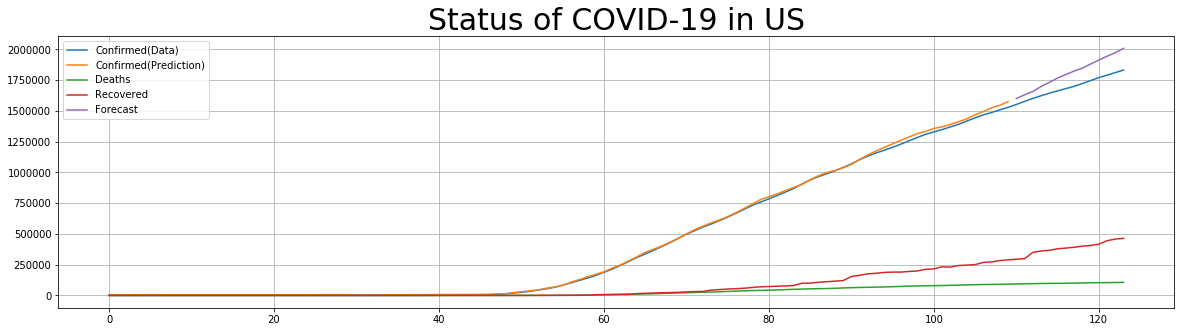

In [11]:
### US
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 5)

df_output_2.Confirmed.plot(grid=True)
df_output_2.Prediction.plot(grid=True)
df_output_2.Deaths.plot(grid=True)
df_output_2.Recovered.plot(grid=True)
df_output_2.Forecast.plot(grid=True)
plt.legend(['Confirmed(Data)', 'Confirmed(Prediction)', 'Deaths', 'Recovered', 'Forecast'])
plt.title("Status of COVID-19 in " + country, fontsize=30)
plt.show()

In [12]:

name = "./" + country + " predict_lstm.csv"
df_output_2.to_csv(name)